Pb 1 - realizati subesantionarea pe fiecare plan de culoare cu pasul 4. Dupa esantionare aplicati o transformare neliniara cu gamma = 0.45 fiecarui plan de culoare

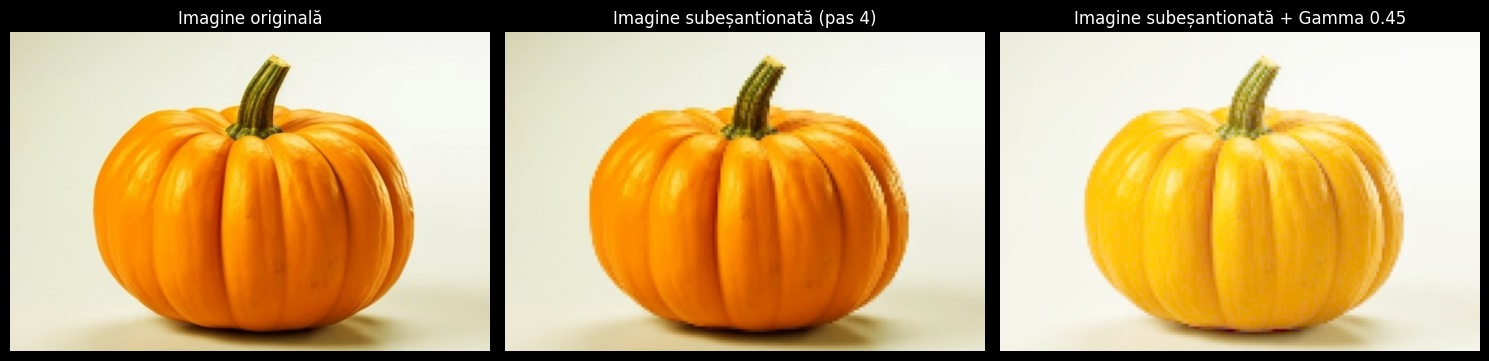

In [8]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
from scipy import signal
plt.style.use('dark_background')

# Citirea imaginii
img = io.imread('dovleac.png')
img = img / 255.0  # Normalizare în intervalul [0, 1]

# 2. Subeșantionare pe fiecare plan de culoare cu pasul 4
R = img[::4, ::4, 0]  # Planul roșu
G = img[::4, ::4, 1]  # Planul verde
B = img[::4, ::4, 2]  # Planul albastru

# 3. Aplicarea transformării neliniare (Gamma = 0.45)
gamma = 0.45
R_gamma = np.power(R, gamma)
G_gamma = np.power(G, gamma)
B_gamma = np.power(B, gamma)

# 4. Reconstruim imaginea procesată
img_gamma = np.stack((R_gamma, G_gamma, B_gamma), axis=2)

# 5. Afișare rezultate
plt.figure(figsize=(15, 5))

# Imaginea originală
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Imagine originală")
plt.axis("off")

# Imaginea subeșantionată
plt.subplot(1, 3, 2)
plt.imshow(np.stack((R, G, B), axis=2))
plt.title("Imagine subeșantionată (pas 4)")
plt.axis("off")

# Imaginea după transformarea Gamma
plt.subplot(1, 3, 3)
plt.imshow(img_gamma)
plt.title("Imagine subeșantionată + Gamma 0.45")
plt.axis("off")

plt.tight_layout()
plt.show()


Pb 2 - Creati o functie care sa afecteze 5% dintr-o imagine cu zgomot impulsiv, apoi filtrati imaginea cu ajutorul filtrul median marginal cu o fereastra 5x5 px

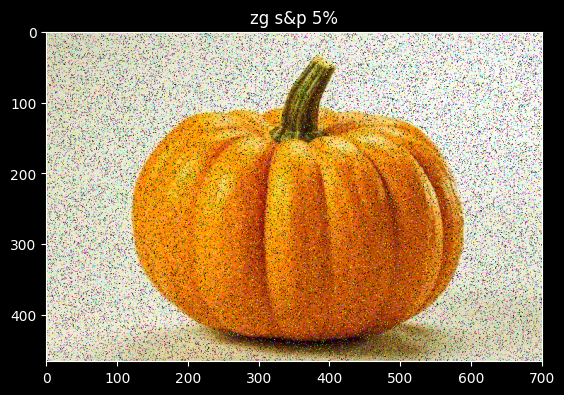

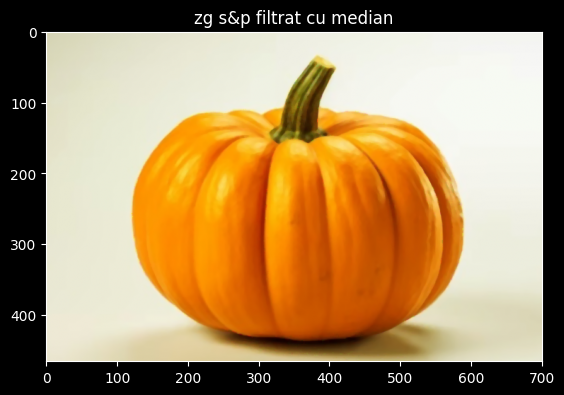

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'zg s&p filtrat cu median'),
 None)

In [9]:
# varianta 2
def median_scalar(img, dim):
    if(np.max(img)>1):
        img = img/255.0
    [L,C] = np.shape(img)
    kernel = np.zeros((dim, dim))
    poz_median = dim*dim//2
    W = dim//2
    kernel[W,W] = 1
    Ybordat = signal.convolve2d(img, kernel, mode='full', boundary = 'symm')
    imgout = np.zeros((L,C))
    for l in range (0, L):
        for c in range (0, C):
            #selecteaza valori conform ferestri plasate (l,c)
            val_selectate = Ybordat[l-W+W:l+W+1+W, c-W+W:c+W+1+W]
            #combina valorile selectate
            val_sortate = np.sort(np.ndarray.flatten(val_selectate))
            #scrie rezultatul in imgout[l,c]
            imgout[l,c]=val_sortate[poz_median]
    return imgout

def median_marginal(img, dim):
    if(np.max(img)>1):
        img = img/255.0
    [L,C,pl] = np.shape(img)
    imgout = np.zeros((L,C,pl))
    for p in range (0, pl):
        imgout[:,:,p] = median_scalar(img[:,:,p], dim)

    return imgout

def add_impulsive_noise(img, p0, p1):  # p0 si p1 sunt probabilitati
    if np.max(img) > 1:  # normalizam la intervalul [0, 1]
        img = img / 255.0
    [L, C, pl] = np.shape(img)
    Nrpix0 = int(L * C * p0)
    Nrpix1 = int(L * C * p1)

    for plan_curent in range(0, pl):
        numere_intregiL = np.random.randint(0, L, [Nrpix0])
        numere_intregiC = np.random.randint(0, C, [Nrpix0])
        img[numere_intregiL, numere_intregiC, plan_curent] = 0

        numere_intregiL = np.random.randint(0, L, [Nrpix1])
        numere_intregiC = np.random.randint(0, C, [Nrpix1])
        img[numere_intregiL, numere_intregiC, plan_curent] = 1

    return img

imgzg_imp = add_impulsive_noise(img, 0.05, 0.05)
plt.figure(), plt.imshow(imgzg_imp), plt.title("zg s&p 5%"), plt.show()

imgfiltrat_med = median_marginal(imgzg_imp,5)
plt.figure(), plt.imshow(imgfiltrat_med), plt.title("zg s&p filtrat cu median"), plt.show()

Pb 3 - Realizati segmentarea pe planul de luminanta a obiectului principal folosind cel putin 2 praguri

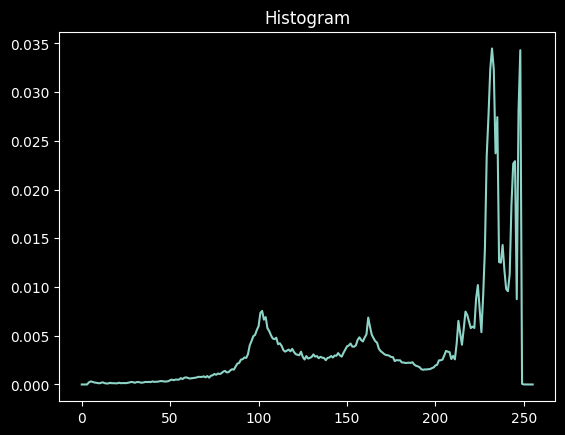

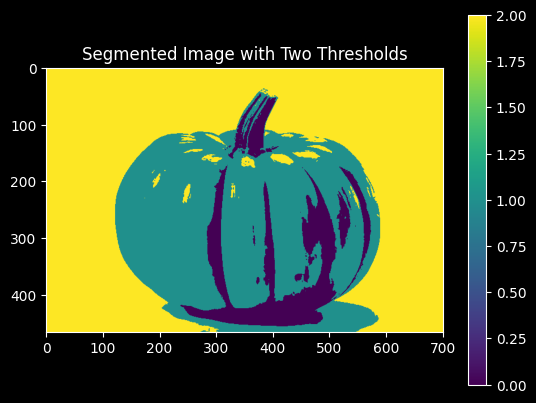

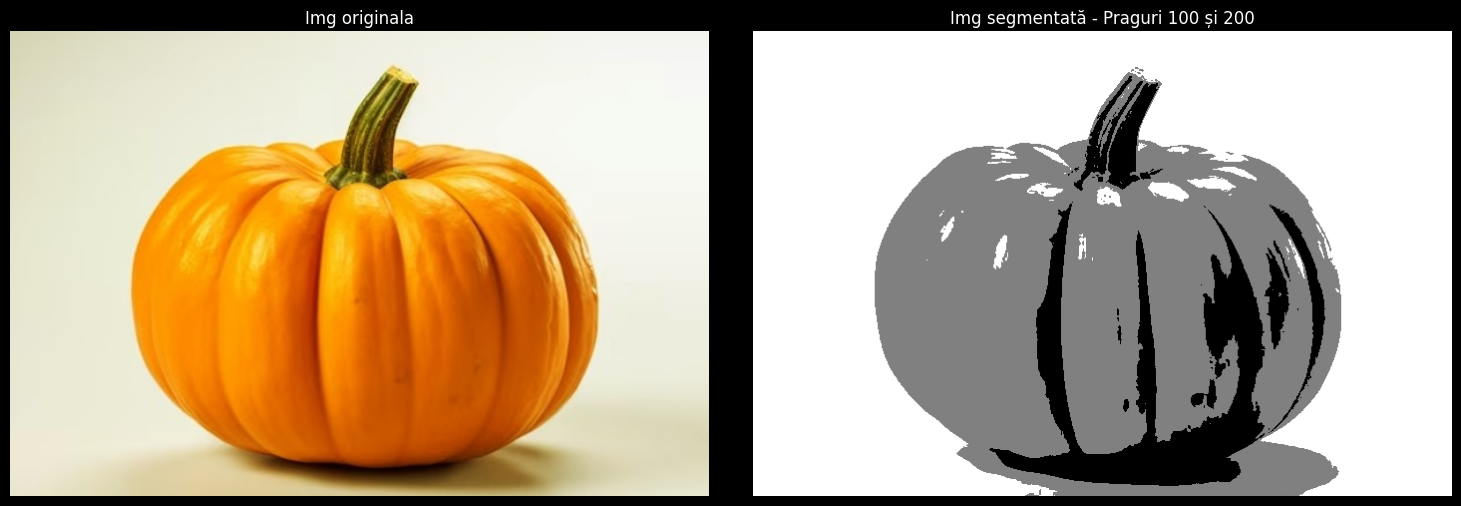

In [13]:
# Funcție pentru segmentarea pe histograma imaginii cu două praguri

def histogram_segmentation_two_thresholds(img, T1, T2):
    Y = np.uint8(255 * color.rgb2gray(img))  # Conversie în grayscale și scalare

    # Calculul histogramei normalizate
    hist, _ = np.histogram(Y, bins=256, range=(0, 256))
    hist = hist / np.sum(hist)

    # Afișarea histogramei
    plt.figure(), plt.plot(hist), plt.title("Histogram"), plt.show()

    # Segmentare folosind două praguri
    [Linii, Coloane] = np.shape(Y)
    out = np.zeros((Linii, Coloane))

    for l in range(0, Linii):
        for c in range(0, Coloane):
            if Y[l, c] > T2:  # Pragul superior
                out[l, c] = 2
            elif Y[l, c] > T1:  # Pragul inferior
                out[l, c] = 1

    # Afișarea rezultatului
    plt.figure(), plt.imshow(out, interpolation=None), plt.colorbar(), plt.title("Segmented Image with Two Thresholds"), plt.show()

    return out

# Imagine de test
img = io.imread('dovleac.png')
img = img[:, :, :3]  # Eliminăm canalul alfa, dacă există

# Segmentarea pe histograma imaginii balansate cu două praguri
segmented_two_thresholds = histogram_segmentation_two_thresholds(img, 100, 200) # prag1 = 100, prag2 = 200

# Afișarea rezultatelor
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title("Img originala")
axs[0].axis("off")

axs[1].imshow(segmented_two_thresholds, cmap='gray')
axs[1].set_title("Img segmentată - Praguri 100 și 200")
axs[1].axis("off")

plt.tight_layout()
plt.show()

Pb 4 - Realizati balansul de alb prin metoda cel mai stralucitor obiect este alb, folosind ca referinta maximul de pe planul de luminanta

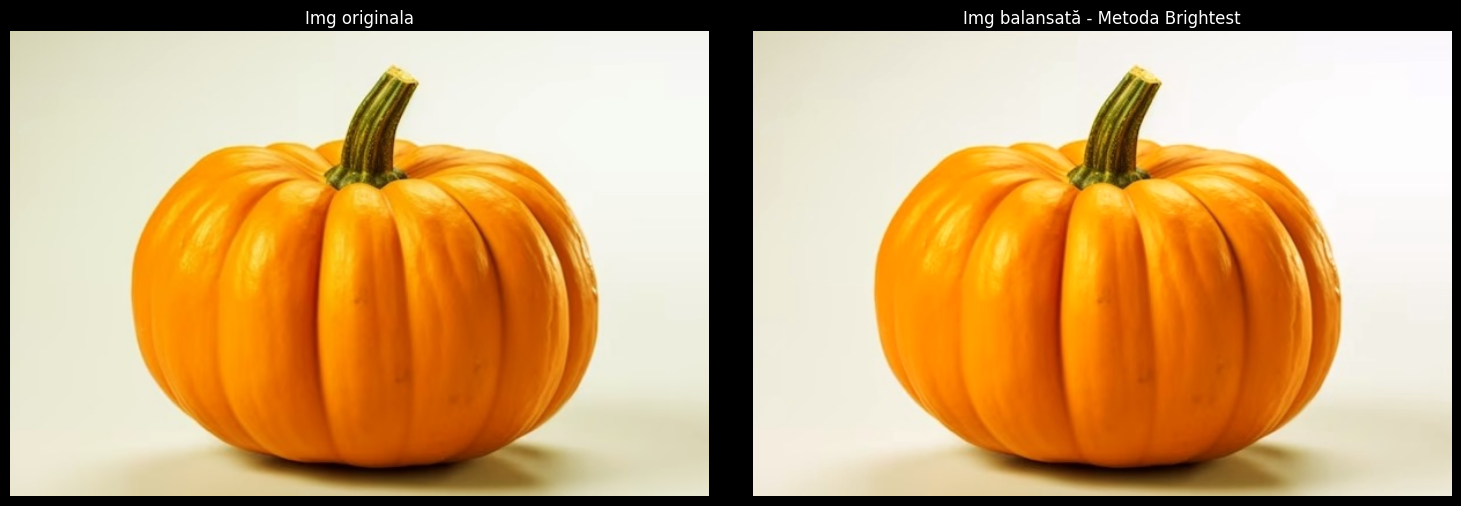

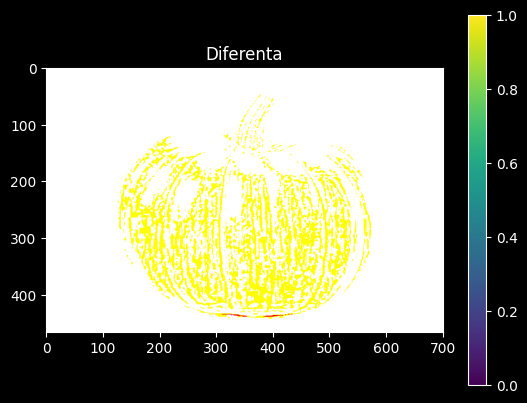

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 1.0, 'Diferenta'),
 None)

In [14]:
def white_balance_brightest(img):
    if np.max(img) > 1:
        img = img / 255.0  # Normalizare în intervalul [0, 1]

    # Convertim imaginea în spațiul YCbCr pentru a găsi luminozitatea maximă
    img_ycbcr = np.zeros_like(img)
    img_ycbcr[:, :, 0] = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]  # Canal Y
    img_ycbcr[:, :, 1] = 128 + (-0.1687 * img[:, :, 0] - 0.3313 * img[:, :, 1] + 0.5 * img[:, :, 2])  # Canal Cb
    img_ycbcr[:, :, 2] = 128 + (0.5 * img[:, :, 0] - 0.4187 * img[:, :, 1] - 0.0813 * img[:, :, 2])  # Canal Cr

    # Găsim indicele pixelului cel mai strălucitor din imagine (Y maxim)
    Y = img_ycbcr[:, :, 0]
    ind = np.unravel_index(np.argmax(Y, axis=None), Y.shape)

    # Extragem valorile maxime pentru canalele R, G și B
    Rmax = img[ind[0], ind[1], 0]
    Gmax = img[ind[0], ind[1], 1]
    Bmax = img[ind[0], ind[1], 2]

    # Ajustarea balansului de alb prin normalizare la valorile maxime
    img[:, :, 0] = img[:, :, 0] / Rmax
    img[:, :, 1] = img[:, :, 1] / Gmax
    img[:, :, 2] = img[:, :, 2] / Bmax

    # Clipăm valorile pentru a rămâne în intervalul [0, 1]
    img_balanced = np.clip(img, 0, 1)
    return img_balanced

# Aplicarea balansului de alb
img_balanced = white_balance_brightest(img)

# Afișarea rezultatelor
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title("Img originala")
axs[0].axis("off")

axs[1].imshow(img_balanced)
axs[1].set_title("Img balansată - Metoda Brightest")
axs[1].axis("off")

plt.tight_layout()
plt.show()

diff = np.float64(img[:,:,0:3]) - np.float64(img_balanced)
plt.figure(), plt.imshow(np.clip(diff, 0, 1)), plt.colorbar(), plt.title("Diferenta"), plt.show()

Pb 5 - Extrageti muchiile folosind nucleele Sobel

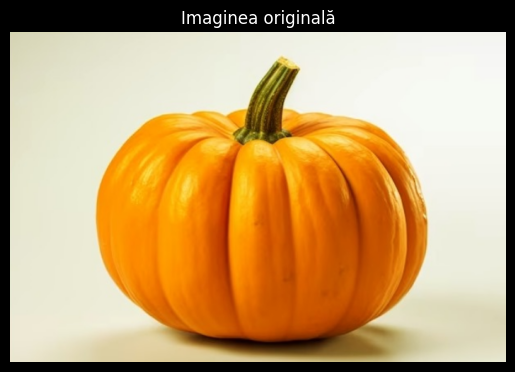

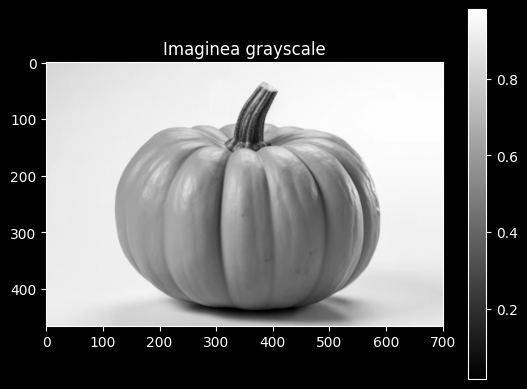

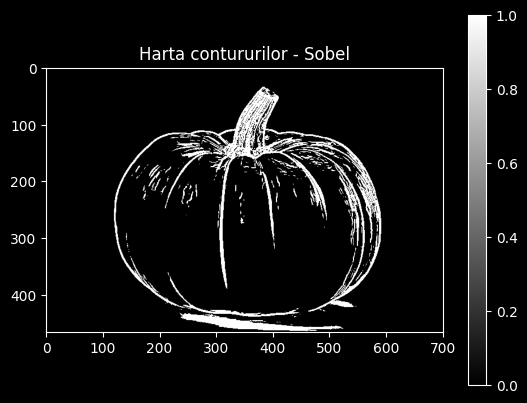

In [12]:
# Funcție pentru extragerea contururilor utilizând gradient Sobel
def extract_sobel_contours(img):
    # Conversia imaginii în grayscale
    Y = color.rgb2gray(img)

    # Kernel Sobel orizontal
    kernelH = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])

    # Kernel Sobel vertical
    kernelV = np.array([
        [-1, -2, -1],
        [ 0,  0,  0],
        [ 1,  2,  1]
    ])

    # Aplicarea convoluției
    YH = signal.convolve2d(Y, kernelH, mode='same', boundary='symm')
    YV = signal.convolve2d(Y, kernelV, mode='same', boundary='symm')

    # Calcularea hărții de intensitate a contururilor
    contur_map = np.sqrt(YH**2 + YV**2)

    # Afișarea rezultatelor
    plt.figure(), plt.imshow(img), plt.title("Imaginea originală"), plt.axis("off"), plt.show()
    plt.figure(), plt.imshow(Y, cmap='gray'), plt.title("Imaginea grayscale"), plt.colorbar(), plt.show()
    plt.figure(), plt.imshow(contur_map >= 0.2, cmap='gray'), plt.title("Harta contururilor - Sobel"), plt.colorbar(), plt.show()

    return contur_map

contour_map_sobel = extract_sobel_contours(img)